# Lopsided Ratings: An Analysis of Yelp Reviews##

Source: Yelp Dataset Challenge

In [1]:
source("RStart.R")

options(repr.plot.mimetypes = 'image/png', repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)

options(jupyter.plot_mimetypes = 'image/png')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: package ‘ggplot2’ was built under R version 3.2.3Registering fonts with R

Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



# Processing the Data

In [2]:
review_df <- read_csv("yelp/yelp_academic_dataset_review.csv")

In [3]:
names(review_df)

[1] "user_id"      "review_id"    "text"         "votes.cool"   "business_id" 
 [6] "votes.funny"  "stars"        "date"         "type"         "votes.useful"

In [4]:
nrow(review_df)

[1] 1569264

First, let's focus on the ratings rather than the reviews

In [5]:
columns <- c("stars", "date")

ratings_df <- review_df %>%
        select(which(names(review_df) %in% columns))

head(ratings_df)

,stars,date
1,5,2007-05-17
2,2,2010-03-22
3,4,2012-02-14
4,4,2012-03-02
5,4,2012-05-15
6,1,2013-04-19


# Yelp Ratings Overall

In [6]:
ratings_breakdown <- ratings_df %>%
    group_by(stars) %>%
    summarize(count=n()) %>%
    mutate(percent = count / sum(count), sum=sum(count))

ratings_breakdown$stars <- factor(ratings_breakdown$stars, 
                              level=1:5, 
                              label=c("1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"))

head(ratings_breakdown)

,stars,count,percent,sum
1,1 Star,159811,0.1018382,1569264
2,2 Stars,140608,0.08960124,1569264
3,3 Stars,222719,0.1419258,1569264
4,4 Stars,466599,0.2973362,1569264
5,5 Stars,579527,0.3692986,1569264


### Overall, 5-star ratings make up the largest proportion of ratings on Yelp.

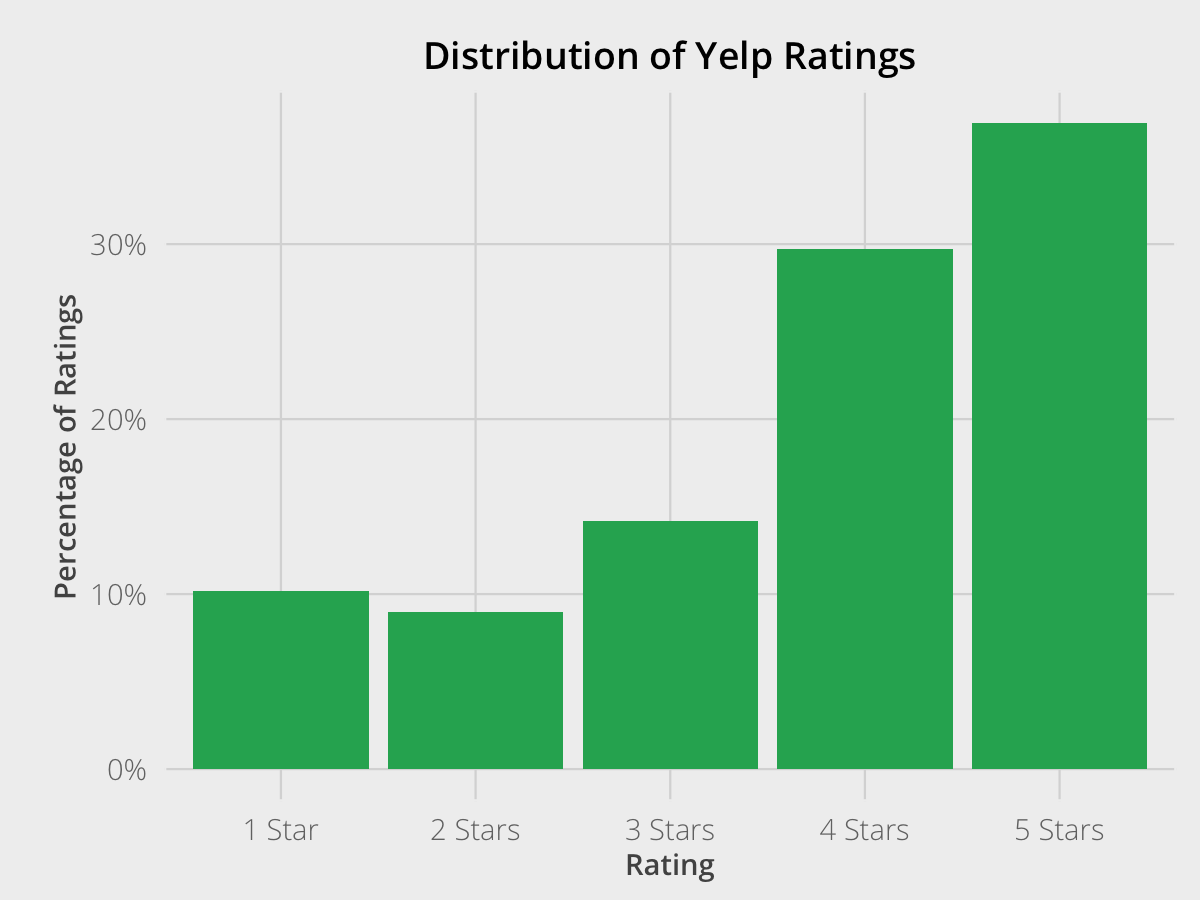

In [7]:
plot <- ggplot(ratings_breakdown, aes(x=stars, y=percent)) + 
            geom_bar(stat="identity", fill="#27AE60") + 
            fte_theme() + 
            scale_y_continuous(labels = scales::percent) +
            labs(x="Rating", y="Percentage of Ratings", title="Distribution of Yelp Ratings")  

plot

# Yelp Ratings over Time

In [8]:
ratings_daily <- ratings_df %>%
    group_by(date) %>%
    summarize(count = n()) %>%
    arrange(date)

head(ratings_daily)

,date,count
1,2004-10-12,2
2,2004-10-18,1
3,2004-10-19,6
4,2004-10-24,1
5,2004-10-26,1
6,2004-12-19,2


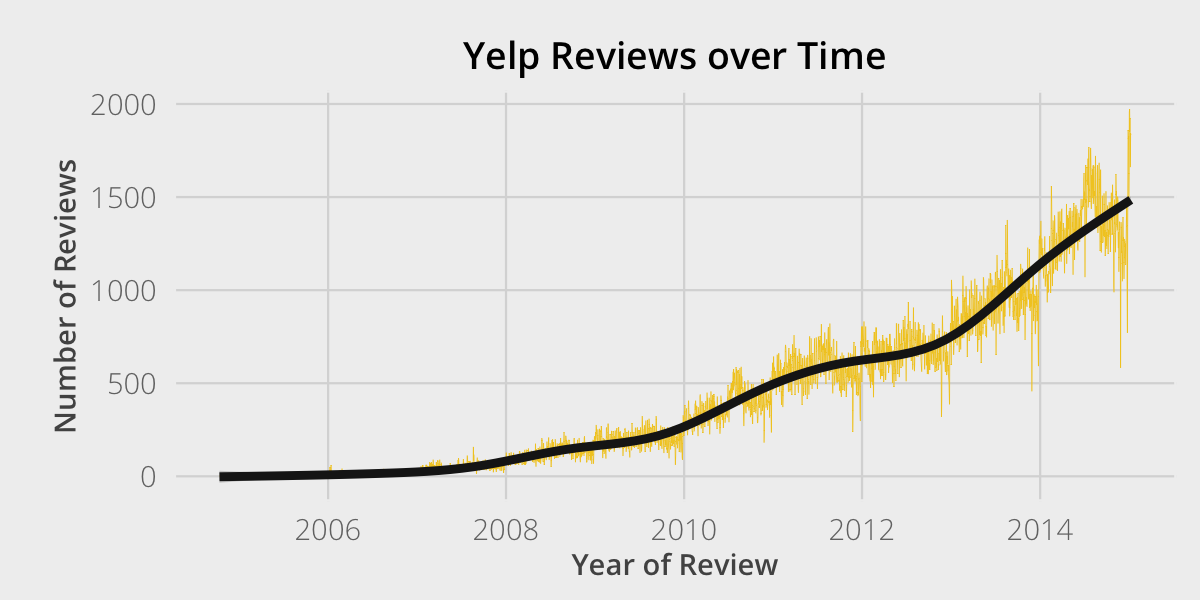

In [9]:
plot <- ggplot(ratings_daily, aes(x=date, y=count)) +
            geom_line(color="#F2CA27", size=0.1) +
            geom_smooth(color="#1A1A1A") + 
            fte_theme() + 
            labs(x="Year of Review", y="Number of Reviews", title="Yelp Reviews over Time")

options(repr.plot.height=2)

plot

### How have the individual ratings changed over time? 

To account for the increased traffic on Yelp over time, we need to normalize each rating by the total ratings each day. With this, we can instead show the proportion of a given rating over time. 

Additionally, since there were significantly less reviews in 2004 and 2005, we'll filter out days where there weren't more than 50 reviews to make our analysis more robust. 

In [10]:
ratings_stars <- ratings_df %>%
    group_by(date, stars) %>%
    summarize(count = n()) %>%
    group_by(date) %>%
    mutate(norm = count / sum(count), sum = sum(count)) %>%
    filter(sum > 50)

ratings_stars$stars <- factor(ratings_stars$stars, 
                              level=1:5, 
                              label=c("1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"))

head(ratings_stars)

,date,stars,count,norm,sum
1,2006-01-13,1 Star,3,0.05,60
2,2006-01-13,2 Stars,3,0.05,60
3,2006-01-13,3 Stars,9,0.15,60
4,2006-01-13,4 Stars,19,0.3166667,60
5,2006-01-13,5 Stars,26,0.4333333,60
6,2007-01-17,1 Star,2,0.03773585,53


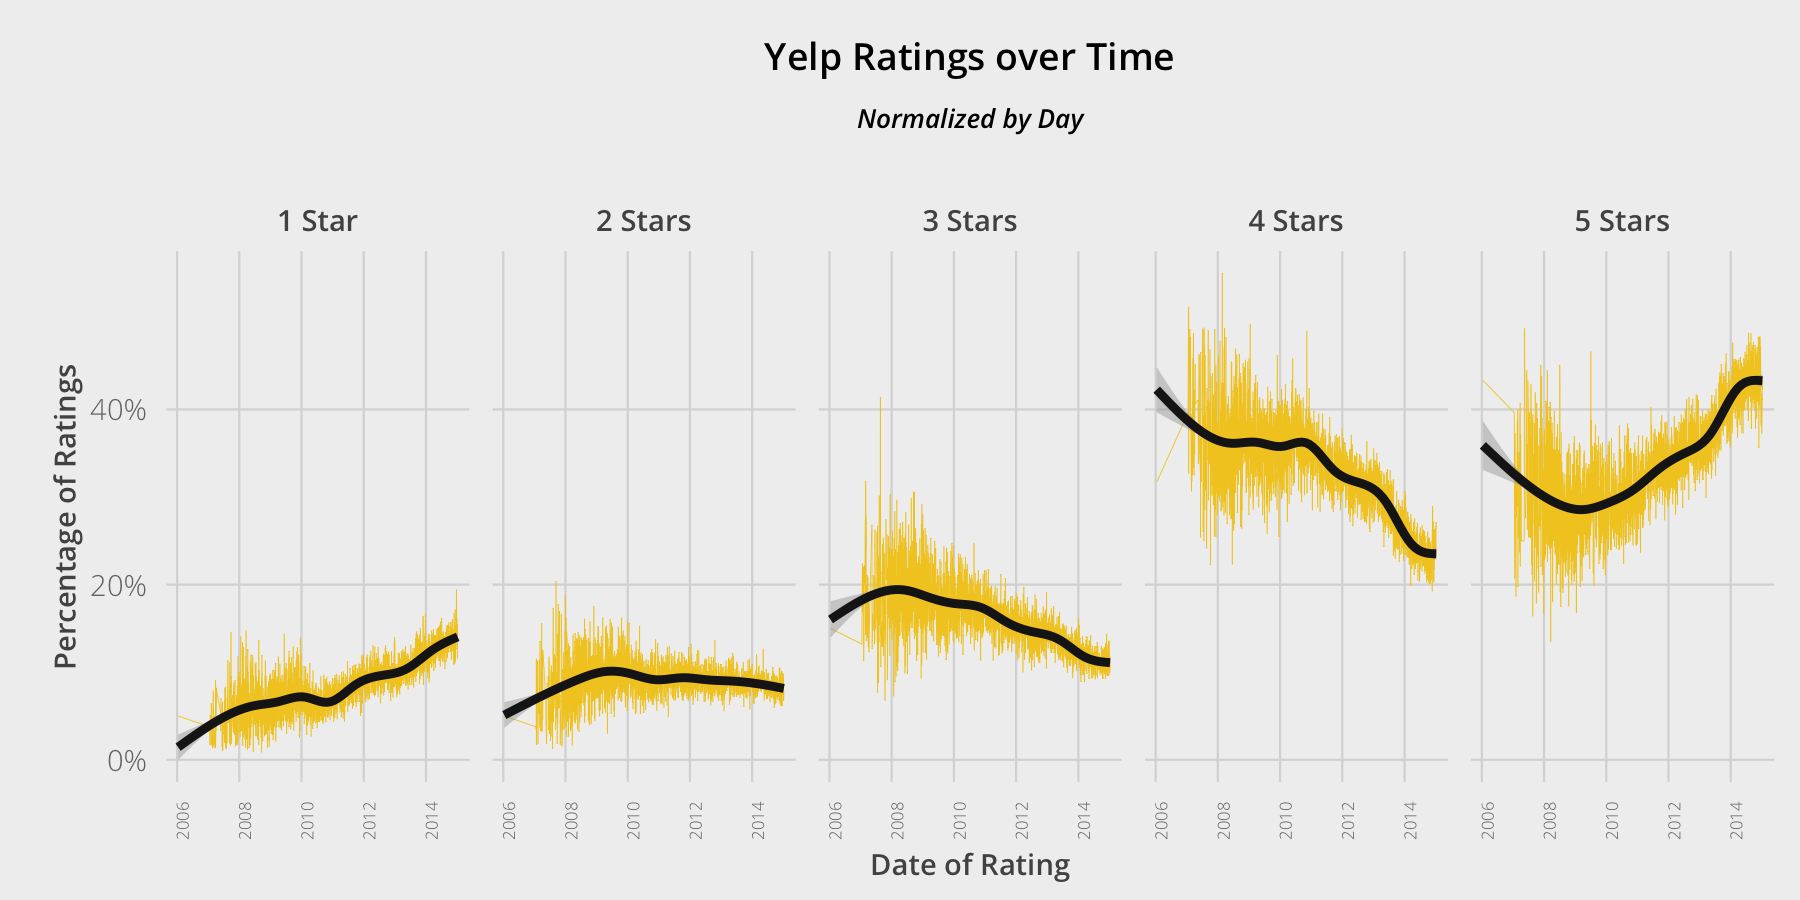

In [11]:
plot <- ggplot(ratings_stars, aes(x=date, y=norm)) + 
            geom_line(color="#F2CA27", size=0.1) +
            geom_smooth(color="#1A1A1A") +
            fte_theme() +
            scale_y_continuous(labels = scales::percent) +
            theme(axis.text.x = element_text(angle=90, size=4)) + 
            labs(x="Date of Rating", y="Percentage of Ratings") + 
            ggtitle(expression(atop("Yelp Ratings over Time", 
                               atop(italic("Normalized by Day"), "")))) +
            facet_wrap(~stars, nrow=1)

options(repr.plot.width=6, repr.plot.height=3, tall=T)

plot

# Yelp Rating by Seasonality

In [12]:
ratings_dow <- ratings_stars %>%
    mutate(dow = weekdays(as.Date(date)),
           month = format(as.Date(date), '%B')) %>%
    group_by(dow, month) %>%
    summarize(total = sum(count))

ratings_dow$month <- factor(ratings_dow$month, levels=rev(c("January", "February", "March", "April",
                                                          "May", "June", "July", "August",
                                                          "September", "October", "November", "December")))

ratings_dow$dow <- factor(ratings_dow$dow, levels=c("Sunday", "Monday", "Tuesday", "Wednesday",
                                                  "Thursday", "Friday", "Saturday"))

head(ratings_dow)

,dow,month,total
1,Friday,April,15440
2,Friday,August,20741
3,Friday,December,16739
4,Friday,February,13621
5,Friday,January,17684
6,Friday,July,18070


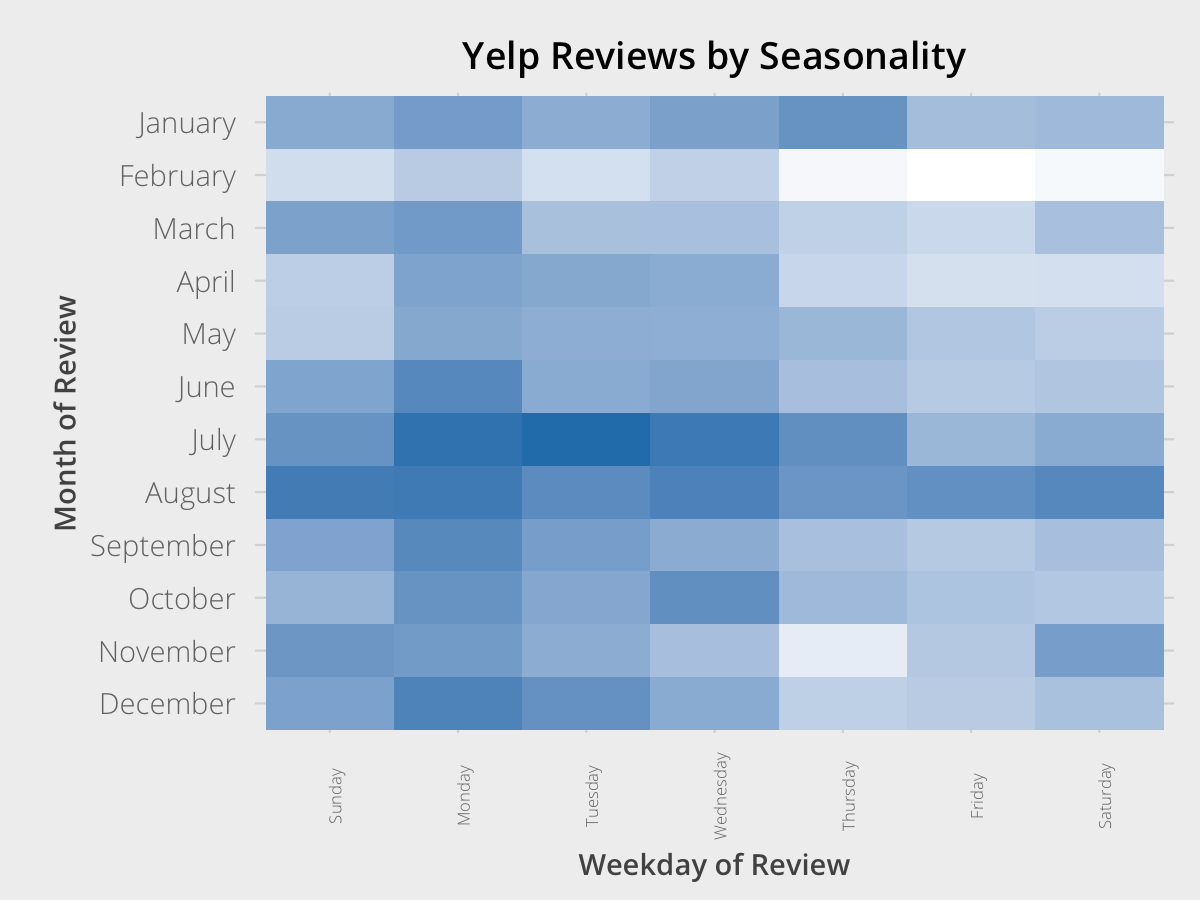

In [13]:
plot <- ggplot(ratings_dow, aes(x=dow, y=month, fill=total)) +
            geom_tile() +
            fte_theme() +
            scale_fill_gradient(low="white", high="#2980B9") +
            theme(axis.text.x=element_text(angle=90, size=4)) + 
            labs(x="Weekday of Review", y="Month of Review", title="Yelp Reviews by Seasonality")

options(repr.plot.width=4, repr.plot.height=3, tall=T)
plot

### How do the individual ratings change depending on seasonality? 

First, we need to find the percentage of each rating by the day of week and month of year. 

Since the range of percentages differ for each rating, we can also index the percentages by each facet

In [16]:
ratings_dow_stars <- ratings_stars %>% 
    mutate(dow = weekdays(as.Date(date)),
           month = format(as.Date(date), '%B')) %>%
    group_by(dow, month, stars) %>% 
    summarize(total = sum(count)) %>% 
    group_by(dow, month) %>%
    mutate(percent = total / sum(total), sum = sum(total)) %>%
    group_by(stars) %>%
    mutate(norm = percent / max(percent) * 100, max = max(percent)) #%>%
   #filter(norm==100)

ratings_dow_stars$month <- factor(ratings_dow_stars$month, levels=rev(c("January", "February", "March", "April",
                                                          "May", "June", "July", "August",
                                                          "September", "October", "November", "December")))

ratings_dow_stars$dow <- factor(ratings_dow_stars$dow, levels=c("Sunday", "Monday", "Tuesday", "Wednesday",
                                                  "Thursday", "Friday", "Saturday"))

head(ratings_dow_stars, n=10)

,dow,month,stars,total,percent,sum,norm,max
1,Friday,April,1 Star,1536,0.09948187,15440,84.43052,0.1178269
2,Friday,April,2 Stars,1408,0.09119171,15440,89.62749,0.1017452
3,Friday,April,3 Stars,2194,0.1420984,15440,90.68678,0.1566915
4,Friday,April,4 Stars,4643,0.3007124,15440,92.77289,0.3241383
5,Friday,April,5 Stars,5659,0.3665155,15440,92.08099,0.398036
6,Friday,August,1 Star,2266,0.1092522,20741,92.72263,0.1178269
7,Friday,August,2 Stars,1854,0.08938817,20741,87.85489,0.1017452
8,Friday,August,3 Stars,2740,0.1321055,20741,84.30931,0.1566915
9,Friday,August,4 Stars,5835,0.2813268,20741,86.79223,0.3241383
10,Friday,August,5 Stars,8046,0.3879273,20741,97.46034,0.398036


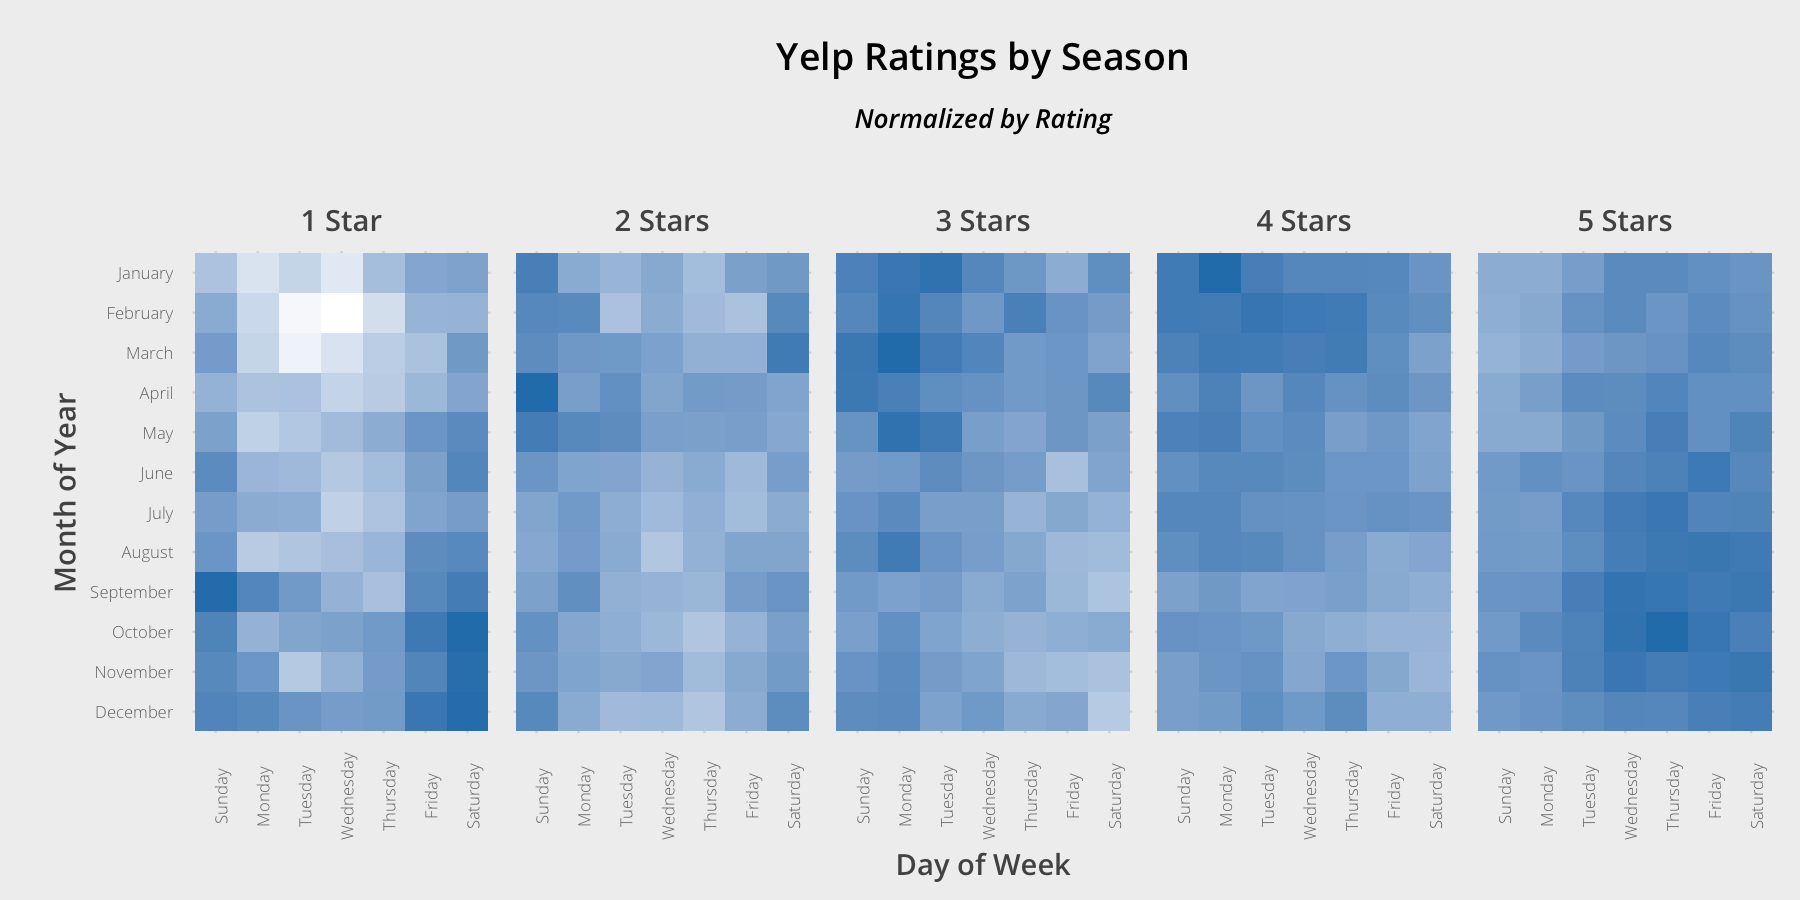

In [15]:
plot <- ggplot(ratings_dow_stars, aes(x=dow, y=month, fill=norm)) +
            geom_tile() + 
            fte_theme() + 
            theme(axis.text.x = element_text(angle=90, size=4), 
                  axis.text.y = element_text(size=4)) + 
            scale_fill_gradient(low="white", high="#2980B9") +
            labs(x="Day of Week", y="Month of Year") +
            ggtitle(expression(atop("Yelp Ratings by Season", atop(italic("Normalized by Rating"), "")))) +
            facet_wrap(~stars, nrow=1)

options(repr.plot.width=6, repr.plot.height=3, tall=T)

plot


# Yelp Reviews

Let's now start to explore the actual text in the reviews. 

In [16]:
names(review_df)

[1] "user_id"      "review_id"    "text"         "votes.cool"   "business_id" 
 [6] "votes.funny"  "stars"        "date"         "type"         "votes.useful"

### Do different ratings have a characteristic word count? 

For this, I'll first find the word count for each review. Similar to the heat maps, I'll also normalize by each facet, to ensure that we don't bias towards ratings that have more or less reviews. 

In [17]:
review_length <- review_df %>%
    select(which(names(review_df) %in% c("text", "business_id", "stars"))) %>%
    mutate(num_words = sapply(gregexpr("[[:alpha:]]+", text), function(x) sum(x > 0))) %>%
    arrange(num_words) %>%
    filter(num_words > 0)

In [18]:
head(review_length)

,text,business_id,stars,num_words
1,Hoofah.,wJr6kSA5dchdgOdwH6dZ2w,2,1
2,Nope!,6p9TlP2I8S4agxYMNFSDjg,1,1
3,ewwww,OZfpG8tDCcIEq8pzgZdyKw,1,1
4,Great,ZL6DNzyenFm9Kpz6uADlNg,1,1
5,A,cuuJJ9W3tYmidaLvlzvPBw,1,1
6,Fabulous!,qUeBDN0D8SC93KeAHhiL-g,5,1


In [19]:
review_length_stars <- review_length %>%
    group_by(stars, num_words) %>%
    summarize(count=n()) %>%
    group_by(stars) %>%
    mutate(norm = count/max(count), max = max(count)) 

review_length_stars$stars <- factor(review_length_stars$stars, 
                                       level=1:5,
                                       labels=c("1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"))

head(review_length_stars)

,stars,num_words,count,norm,max
1,1 Star,1,260,0.2792696,931
2,1 Star,2,149,0.160043,931
3,1 Star,3,245,0.2631579,931
4,1 Star,4,266,0.2857143,931
5,1 Star,5,256,0.2749731,931
6,1 Star,6,290,0.311493,931


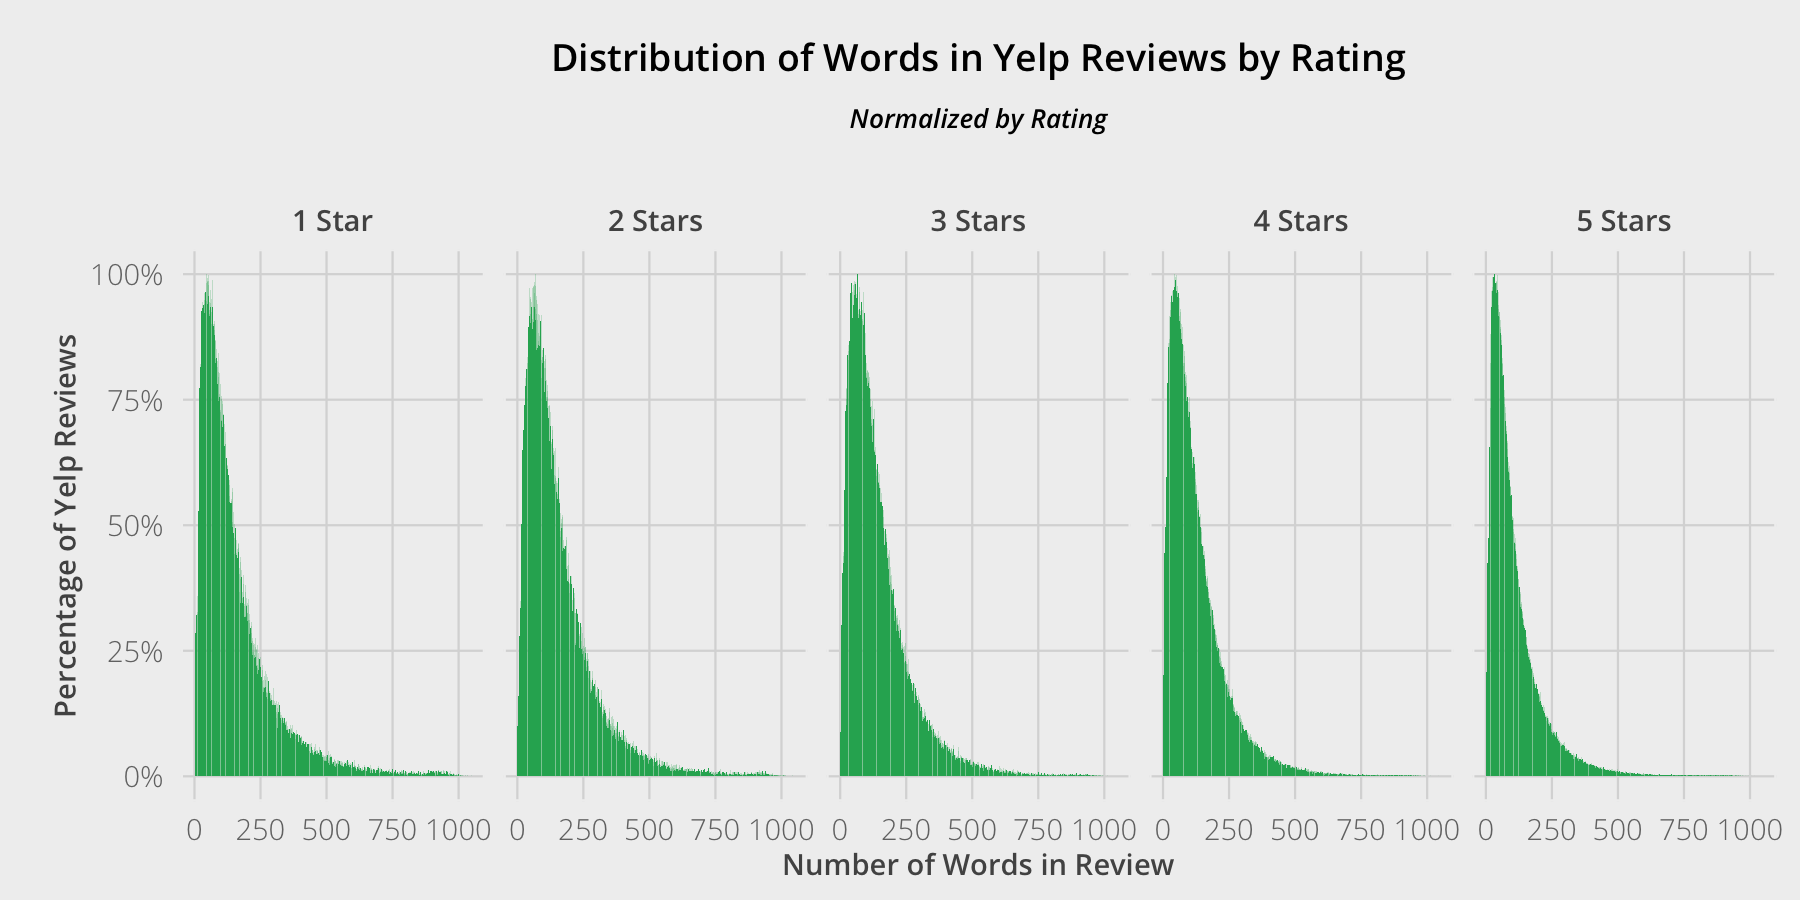

In [20]:
plot <- ggplot(review_length_stars, aes(x=num_words, y=norm)) + 
            geom_bar(stat="identity", fill="#27AE60", position="dodge") + 
             #geom_smooth(color="#1A1A1A", method="loess") +
            fte_theme() + 
            scale_y_continuous(labels = scales::percent) +
            labs(x="Number of Words in Review", y="Percentage of Yelp Reviews") + 
            ggtitle(expression(atop("Distribution of Words in Yelp Reviews by Rating", 
                                    atop(italic("Normalized by Rating"), "")))) +
            facet_wrap(~stars, nrow=1)

options(repr.plot.width=6, repr.plot.height=3, tall=T)

plot

Though there are slight differences amongst the distributions, the overall pattern looks similar between each rating. 

### What are key phrases in different ratings?

Next, let's look at the most frequent 2-word phrases in 1-star vs. 5-star ratings.

In [19]:
df_one_star <- review_df %>% 
                    filter(stars == 1)

df_five_stars <- review_df %>% 
                    filter(stars == 5) 

In [20]:
BigramTokenizer <- function(x) {
    unlist(lapply(ngrams(words(x), 2), paste, collapse = " "), use.names = FALSE)}

In [21]:
create_dtm <- function(x) {
    text <- paste(x$text, collapse = " ")
    
    # removing stop words and lowering text 
    text <- unlist(strsplit(tolower(text), " "))
    text <- paste(unlist(text[which(!(text %in% stopwords("english")))]), collapse= " ")
    
    source <- VectorSource(text)
    corpus <- Corpus(source)
    #corpus <- tm_map(corpus, content_transformer(tolower))
    corpus <- tm_map(corpus, removePunctuation)
    corpus <- tm_map(corpus, removeNumbers)
    corpus <- tm_map(corpus, stripWhitespace)
    dtm <- TermDocumentMatrix(corpus, control = list(tokenize = BigramTokenizer))
    return(dtm)
}

In [22]:
find_freq <- function(x) { 
    df <- as.data.frame(as.matrix(x))
    df$"phrase" <- rownames(df)
    rownames(df) <- 1:length(rownames(df))
    names(df) <- c("frequency", "phrase")
    freq <- arrange(df, desc(frequency))
    return(freq)
}

In [23]:
one_star_phrases <- find_freq(create_dtm(df_one_star))

In [24]:
five_star_phrases <- find_freq(create_dtm(df_five_stars))

In [30]:
head(one_star_phrases, n=10)

,frequency,phrase
1,17894,customer service
2,12280,will never
3,9790,go back
4,6478,first time
5,6190,come back
6,5813,even though
7,5584,front desk
8,5524,never go
9,5043,tasted like
10,5040,las vegas


In [31]:
head(five_star_phrases, n=10)

,frequency,phrase
1,28678,highly recommend
2,25829,las vegas
3,24176,love place
4,22364,first time
5,21355,will definitely
6,21001,go back
7,19656,great service
8,19350,customer service
9,18810,great food
10,17871,great place


The top phrases for 1- and 5-star reviews are what we'd expect, but there is a bit of overlap between the two lists: "customer service" and "las vegas" for example. 

If we find the percentage of reviews each phrase is used in, we can determine if the phrases are more commonly used in 5- or 1-star reviews. 

In [32]:
histogram_reviews <- review_df %>%
    group_by(stars) %>%
    summarize(count=n())
histogram_reviews

,stars,count
1,1,159811
2,2,140608
3,3,222719
4,4,466599
5,5,579527


In [41]:
one_star_phrases$norm_low <- one_star_phrases$frequency / histogram_reviews$count[1]
five_star_phrases$norm_high <- five_star_phrases$frequency / histogram_reviews$count[5]

one_star_phrases <- arrange(one_star_phrases, desc(norm_low))
five_star_phrases <- arrange(five_star_phrases, desc(norm_high))

In [42]:
head(one_star_phrases, n=10)

,frequency,phrase,norm,norm_low
1,17894,customer service,0.1119698,0.1119698
2,12280,will never,0.07684077,0.07684077
3,9790,go back,0.06125986,0.06125986
4,6478,first time,0.04053538,0.04053538
5,6190,come back,0.03873325,0.03873325
6,5813,even though,0.03637422,0.03637422
7,5584,front desk,0.03494127,0.03494127
8,5524,never go,0.03456583,0.03456583
9,5043,tasted like,0.03155603,0.03155603
10,5040,las vegas,0.03153725,0.03153725


In [43]:
head(five_star_phrases, n=10)

,frequency,phrase,norm,norm_high
1,28678,highly recommend,0.04948518,0.04948518
2,25829,las vegas,0.04456911,0.04456911
3,24176,love place,0.04171678,0.04171678
4,22364,first time,0.03859009,0.03859009
5,21355,will definitely,0.03684902,0.03684902
6,21001,go back,0.03623817,0.03623817
7,19656,great service,0.03391732,0.03391732
8,19350,customer service,0.0333893,0.0333893
9,18810,great food,0.0324575,0.0324575
10,17871,great place,0.03083722,0.03083722


We can merge the results of the 1- and 5- star phrases, and create an index value between the normalized frequencies to determine which review a phrase is more closely associated with. 

In [44]:
merged_phrases <- merge(one_star_phrases, five_star_phrases, 
                        by.x="phrase", by.y="phrase")

In [47]:
merged_phrases_df <- merged_phrases %>%
    select(phrase, norm_low, norm_high) %>%
    mutate(index = norm_high/norm_low) %>%
    arrange(desc(index))

head(merged_phrases_df, n=20)

,phrase,norm_low,norm_high,index
1,extremely reasonable,6.257392e-06,0.0009870118,157.7353
2,amazing too,6.257392e-06,0.0009835607,157.1838
3,recommend highly,6.257392e-06,0.0008972835,143.3958
4,wish open,6.257392e-06,0.0008092807,129.332
5,perfect blend,6.257392e-06,0.0007902997,126.2986
6,delicious love,1.251478e-05,0.001432202,114.4409
7,delicious highly,6.257392e-06,0.0006919436,110.5802
8,fantastic well,6.257392e-06,0.0006798648,108.6499
9,definitely check,1.251478e-05,0.001358004,108.512
10,always attentive,6.257392e-06,0.0006764137,108.0983


In [48]:
tail(merged_phrases_df, n=20)

,phrase,norm_low,norm_high,index
1685206,literally worst,0.0008259757,1.725545e-06,0.002089099
1685207,rudely said,0.0008259757,1.725545e-06,0.002089099
1685208,manager refused,0.0009386087,1.725545e-06,0.001838407
1685209,poorly managed,0.0009698957,1.725545e-06,0.001779104
1685210,manager finally,0.0009761531,1.725545e-06,0.001767699
1685211,this worst,0.0009824105,1.725545e-06,0.00175644
1685212,completely unacceptable,0.00100744,1.725545e-06,0.001712802
1685213,hands worst,0.001107558,1.725545e-06,0.001557972
1685214,horrible horrible,0.003529169,5.176635e-06,0.001466814
1685215,worst sushi,0.001226449,1.725545e-06,0.001406944


In [51]:
five_star_associations <- head(merged_phrases_df, 2000)
one_star_associations <- tail(merged_phrases_df, 2000)
write.csv(one_star_associations, "Yelp_onestar_associations.csv")
write.csv(five_star_associations, "Yelp_fivestar_associations.csv")